# Perform A/B Test using REST Endpoints

### Note: This notebook requires that model.tar.gz already contains code/inference.py

_This won't work unless that's the case.  (I can't seem to specify `entry_point` and `source_dir`._

You can test and deploy new models behind a single SageMaker Endpoint with a concept called “production variants.” These variants can differ by hardware (CPU/GPU), by data (comedy/drama movies), or by region (US West or Germany North). You can shift traffic between the models in your endpoint for canary rollouts and blue/green deployments. You can split traffic for A/B tests. And you can configure your endpoint to automatically scale your endpoints out or in based on a given metric like requests per second. As more requests come in, SageMaker will automatically scale the model prediction API to meet the demand.

<img src="img/model_ab.png" width="80%" align="left">

We can use traffic splitting to direct subsets of users to different model variants for the purpose of comparing and testing different models in live production. The goal is to see which variants perform better. Often, these tests need to run for a long period of time (weeks) to be statistically significant. The figure shows 2 different recommendation models deployed using a random 50-50 traffic split between the 2 variants.

In [1]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

sm = boto3.Session().client(service_name="sagemaker", region_name=region)
cw = boto3.Session().client(service_name="cloudwatch", region_name=region)

# Clean Up Previous Endpoints to Save Resources

In [2]:
%store -r autopilot_endpoint_name

no stored variable or alias autopilot_endpoint_name


In [3]:
try:
    autopilot_endpoint_name
    sm.delete_endpoint(EndpointName=autopilot_endpoint_name)
    print("Autopilot Endpoint has been deleted to save resources.  This is good.")
except:
    print("Endpoints are cleaned up.  This is good.  Keep moving forward!")

Endpoints are cleaned up.  This is good.  Keep moving forward!


In [4]:
%store -r training_job_name

In [5]:
print(training_job_name)

tensorflow-training-2024-03-03-04-02-13-539


# Copy the Model to the Notebook

In [6]:
!aws s3 cp s3://$bucket/$training_job_name/output/model.tar.gz ./model.tar.gz

download: s3://sagemaker-us-east-1-211125778552/tensorflow-training-2024-03-03-04-02-13-539/output/model.tar.gz to ./model.tar.gz


In [7]:
!mkdir -p ./model/
!tar -xvzf ./model.tar.gz -C ./model/

tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
metrics/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
metrics/evaluation.json
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
metrics/confusion_matrix.png
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tensorboard/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tensorboard/train/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tensorboard/train/plugins/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tensorboard/train/plugins/profile/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tensorboard/train/plugins/profile/2024_03_03_04_06_31/
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.creationtime'
tensorboard/train/plugins/profile/2024_03_03_04_06_31/ip-10-0-71-63.ec2.internal.tensorflow_stats.pb
tar: Ignoring unknown extended header ke

# Show the Prediction Signature

In [8]:
!saved_model_cli show --all --dir ./model/tensorflow/saved_model/0/

2024-03-07 00:38:48.258102: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2024-03-07 00:38:48.258136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_ids'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 64)
        name: serving_defau

# Show `inference.py`

In [9]:
!pygmentize ./model/code/inference.py

import json
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "tensorflow==2.3.1"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "transformers==3.5.1"])
# Workaround for https://github.com/huggingface/tokenizers/issues/120 and
#                https://github.com/kaushaltrivedi/fast-bert/issues/174
# subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--upgrade', 'tokenizers'])

import tensorflow as tf
from transformers import DistilBertTokenizer

classes = [1, 2, 3, 4, 5]

max_seq_length = 64

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")


def input_handler(data, context):
    data_str = data.read().decode("utf-8")
    print("data_str: {}".format(data_str))
    print("type data_str: {}".format(type(data_str)))

    jsonlines = data_str.split("\n")
    print("jsonlines: {}".format(jsonlines))
    print("type jsonlines: {}".format(type(jsonlines)))

    transformed_instances = []

    f

# Create Variant A Model From the Training Job in a Previous Section

Notes:
* `primary_container_image` is required because the inference and training images are different.
* By default, the training image will be used, so we need to override it.  
* See https://github.com/aws/sagemaker-python-sdk/issues/1379
* If you are not using a US-based region, you may need to adapt the container image to your current region using the following table:

https://docs.aws.amazon.com/deep-learning-containers/latest/devguide/deep-learning-containers-images.html

In [10]:
inference_image_uri = sagemaker.image_uris.retrieve(
    framework="tensorflow",
    region=region,
    version="2.3.1",
    py_version="py37",
    instance_type="ml.m5.4xlarge",
    image_scope="inference",
)
print(inference_image_uri)

763104351884.dkr.ecr.us-east-1.amazonaws.com/tensorflow-inference:2.3.1-cpu


In [11]:
import time

timestamp = "{}".format(int(time.time()))

model_a_name = "{}-{}-{}".format(training_job_name, "varianta", timestamp)

sess.create_model_from_job(
    name=model_a_name, training_job_name=training_job_name, role=role, image_uri=inference_image_uri
)

'tensorflow-training-2024-03-03-04-02-13-539-varianta-1709771944'

# Create Variant B Model From the Training Job in a Previous Section
Notes:
* `primary_container_image` is required because the inference and training images are different.
* By default, the training image will be used, so we need to override it.  See https://github.com/aws/sagemaker-python-sdk/issues/1379
* If you are not using a US-based region, you may need to adapt the container image to your current region using the following table:

https://docs.aws.amazon.com/deep-learning-containers/latest/devguide/deep-learning-containers-images.html

In [12]:
model_b_name = "{}-{}-{}".format(training_job_name, "variantb", timestamp)

sess.create_model_from_job(
    name=model_b_name, training_job_name=training_job_name, role=role, image_uri=inference_image_uri
)

'tensorflow-training-2024-03-03-04-02-13-539-variantb-1709771944'

# Canary Rollouts and A/B Testing

Canary rollouts are used to release new models safely to only a small subset of users such as 5%. They are useful if you want to test in live production without affecting the entire user base. Since the majority of traffic goes to the existing model, the cluster size of the canary model can be relatively small since it’s only receiving 5% traffic.

Instead of `deploy()`, we can create an `Endpoint Configuration` with multiple variants for canary rollouts and A/B testing.

In [13]:
from sagemaker.session import production_variant

timestamp = "{}".format(int(time.time()))

endpoint_config_name = "{}-{}-{}".format(training_job_name, "abtest", timestamp)

variantA = production_variant(
    model_name=model_a_name,
    instance_type="ml.m5.4xlarge",
    initial_instance_count=1,
    variant_name="VariantA",
    initial_weight=50,
)

variantB = production_variant(
    model_name=model_b_name,
    instance_type="ml.m5.4xlarge",
    initial_instance_count=1,
    variant_name="VariantB",
    initial_weight=50,
)

endpoint_config = sm.create_endpoint_config(
    EndpointConfigName=endpoint_config_name, ProductionVariants=[variantA, variantB]
)

In [14]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpointConfig/{}">REST Endpoint Configuration</a></b>'.format(
            region, endpoint_config_name
        )
    )
)

In [15]:
model_ab_endpoint_name = "{}-{}-{}".format(training_job_name, "abtest", timestamp)

endpoint_response = sm.create_endpoint(EndpointName=model_ab_endpoint_name, EndpointConfigName=endpoint_config_name)

# Store Endpoint Name for Next Notebook(s)

In [16]:
%store model_ab_endpoint_name

Stored 'model_ab_endpoint_name' (str)


# Track the Deployment Within our Experiment

In [17]:
%store -r experiment_name

In [18]:
print(experiment_name)

Amazon-Customer-Reviews-BERT-Experiment-1709436495


In [19]:
%store -r trial_name

In [20]:
print(trial_name)

trial-1709436495


In [21]:
from smexperiments.trial import Trial

timestamp = "{}".format(int(time.time()))

trial = Trial.load(trial_name=trial_name)
print(trial)

Trial(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7feb1319a8d0>,trial_name='trial-1709436495',trial_arn='arn:aws:sagemaker:us-east-1:211125778552:experiment-trial/trial-1709436495',display_name='trial-1709436495',experiment_name='Amazon-Customer-Reviews-BERT-Experiment-1709436495',creation_time=datetime.datetime(2024, 3, 3, 3, 28, 16, 49000, tzinfo=tzlocal()),created_by={'UserProfileArn': 'arn:aws:sagemaker:us-east-1:211125778552:user-profile/d-k0wihxzgpgsi/default-user', 'UserProfileName': 'default-user', 'DomainId': 'd-k0wihxzgpgsi'},last_modified_time=datetime.datetime(2024, 3, 6, 17, 15, 32, 836000, tzinfo=tzlocal()),last_modified_by={'UserProfileArn': 'arn:aws:sagemaker:us-east-1:211125778552:user-profile/d-k0wihxzgpgsi/default-user'},response_metadata={'RequestId': 'f79cc6a4-3754-43b9-892e-3acd9773d02a', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f79cc6a4-3754-43b9-892e-3acd9773d02a', 'content-type': 'application/x-amz-json-1.1', 'content-length'

In [22]:
from smexperiments.tracker import Tracker

tracker_deploy = Tracker.create(display_name="deploy", sagemaker_boto_client=sm)

deploy_trial_component_name = tracker_deploy.trial_component.trial_component_name
print("Deploy trial component name {}".format(deploy_trial_component_name))

Deploy trial component name TrialComponent-2024-03-07-003909-rumw


# Attach the `deploy` Trial Component and Tracker as a Component to the Trial

In [23]:
trial.add_trial_component(tracker_deploy.trial_component)

# Track the Endpoint Name

In [24]:
tracker_deploy.log_parameters(
    {
        "endpoint_name": model_ab_endpoint_name,
    }
)

# must save after logging
tracker_deploy.trial_component.save()

TrialComponent(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7feb13839a90>,trial_component_name='TrialComponent-2024-03-07-003909-rumw',display_name='deploy',tags=None,trial_component_arn='arn:aws:sagemaker:us-east-1:211125778552:experiment-trial-component/TrialComponent-2024-03-07-003909-rumw',response_metadata={'RequestId': '7df05e8d-c034-4850-bbc1-46d5c82404a7', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '7df05e8d-c034-4850-bbc1-46d5c82404a7', 'content-type': 'application/x-amz-json-1.1', 'content-length': '129', 'date': 'Thu, 07 Mar 2024 00:39:09 GMT'}, 'RetryAttempts': 0},parameters={'endpoint_name': 'tensorflow-training-2024-03-03-04-02-13-539-abtest-1709771948'},input_artifacts={},output_artifacts={})

In [25]:
from sagemaker.analytics import ExperimentAnalytics

lineage_table = ExperimentAnalytics(
    sagemaker_session=sess,
    experiment_name=experiment_name,
    metric_names=["validation:accuracy"],
    sort_by="CreationTime",
    sort_order="Ascending",
)

lineage_df = lineage_table.dataframe()
lineage_df.shape

(6, 71)

In [26]:
lineage_df

,TrialComponentName,DisplayName,SourceArn,AWS_DEFAULT_REGION,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,SageMaker.ImageUri - MediaType,SageMaker.ImageUri - Value,code - MediaType,...,SageMaker.DebugHookOutput - MediaType,SageMaker.DebugHookOutput - Value,SageMaker.ModelArtifact - MediaType,SageMaker.ModelArtifact - Value,evaluation-data-s3-uri - MediaType,evaluation-data-s3-uri - Value,model-tar-s3-uri - MediaType,model-tar-s3-uri - Value,metrics - MediaType,metrics - Value
0,sagemaker-scikit-learn-2024-03-03-03-28-16-715...,prepare,arn:aws:sagemaker:us-east-1:211125778552:proce...,us-east-1,2.0,ml.t3.medium,30.0,NaN,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sagemaker-scikit-learn-2024-03-03-03-46-55-548...,prepare,arn:aws:sagemaker:us-east-1:211125778552:proce...,us-east-1,2.0,ml.c5.2xlarge,30.0,NaN,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tensorflow-training-2024-03-03-04-02-13-539-aw...,train,arn:aws:sagemaker:us-east-1:211125778552:train...,NaN,1.0,ml.c4.2xlarge,1024.0,NaN,NaN,NaN,...,NaN,s3://sagemaker-us-east-1-211125778552/,NaN,s3://sagemaker-us-east-1-211125778552/tensorfl...,NaN,NaN,NaN,NaN,NaN,NaN
3,sagemaker-scikit-learn-2024-03-06-15-39-19-291...,evaluate,arn:aws:sagemaker:us-east-1:211125778552:proce...,NaN,1.0,ml.m5.xlarge,30.0,NaN,683313688378.dkr.ecr.us-east-1.amazonaws.com/s...,NaN,...,NaN,NaN,NaN,NaN,NaN,s3://sagemaker-us-east-1-211125778552/amazon-r...,NaN,s3://sagemaker-us-east-1-211125778552/tensorfl...,NaN,s3://sagemaker-us-east-1-211125778552/sagemake...
4,TrialComponent-2024-03-06-163102-dwoe,optimize-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TrialComponent-2024-03-06-165147-drsw,optimize-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint</a></b>'.format(
            region, model_ab_endpoint_name
        )
    )
)

# _Wait Until the Endpoint is Deployed_

In [28]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

# _Wait Until the ^^ Endpoint ^^ is Deployed_

# Simulate a Prediction from an Application

In [29]:
from sagemaker.tensorflow.model import TensorFlowPredictor
from sagemaker.serializers import JSONLinesSerializer
from sagemaker.deserializers import JSONLinesDeserializer

predictor = TensorFlowPredictor(
    endpoint_name=model_ab_endpoint_name,
    sagemaker_session=sess,
    model_name="saved_model",
    model_version=0,
    content_type="application/jsonlines",
    accept_type="application/jsonlines",
    serializer=JSONLinesSerializer(),
    deserializer=JSONLinesDeserializer(),
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Waiting for the Endpoint to be ready to Serve Predictions

In [30]:
import time

time.sleep(30)

# Predict the `star_rating` with Ad Hoc `review_body` Samples

In [31]:
inputs = [{"features": ["This is great!"]}, {"features": ["This is bad."]}]

predicted_classes = predictor.predict(inputs)

for predicted_class in predicted_classes:
    print("Predicted star_rating: {}".format(predicted_class))

Predicted star_rating: {'predicted_label': 5}
Predicted star_rating: {'predicted_label': 1}


# Predict the `star_rating` with `review_body` Samples from our TSV's

In [32]:
import csv

df_reviews = pd.read_csv(
    "./data/amazon_reviews_us_Digital_Software_v1_00.tsv.gz",
    delimiter="\t",
    quoting=csv.QUOTE_NONE,
    compression="gzip",
)
df_sample_reviews = df_reviews[["review_body", "star_rating"]].sample(n=50)
df_sample_reviews = df_sample_reviews.reset_index()
df_sample_reviews.shape

(50, 3)

In [33]:
import pandas as pd


def predict(review_body):
    inputs = [{"features": [review_body]}]
    predicted_classes = predictor.predict(inputs)
    return predicted_classes[0]["predicted_label"]


df_sample_reviews["predicted_class"] = df_sample_reviews["review_body"].map(predict)
df_sample_reviews.head(5)

,index,review_body,star_rating,predicted_class
0,94784,This envelope printer makes my job easy. It st...,5,5
1,32426,This did not work. Everything seemed to go wel...,1,1
2,87898,Would rate higher if TurboTax didn't remove fu...,3,3
3,59292,"over a month since purchase, unable to use sen...",1,1
4,55344,Now I can feel safe about surfing the web know...,5,5


# Review the REST Endpoint Performance Metrics in CloudWatch

In [34]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint Performance Metrics</a></b>'.format(
            region, model_ab_endpoint_name
        )
    )
)

# Review the REST Endpoint Performance Metrics in a Dataframe

Amazon SageMaker emits metrics such as Latency and Invocations (full list of metrics [here](https://alpha-docs-aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)) for each variant in Amazon CloudWatch. Let’s query CloudWatch to get the InvocationsPerVariant to show how invocations are split across variants.

In [35]:
from datetime import datetime, timedelta

import boto3
import pandas as pd


def get_invocation_metrics_for_endpoint_variant(
    endpoint_name, namespace_name, metric_name, variant_name, start_time, end_time
):
    metrics = cw.get_metric_statistics(
        Namespace=namespace_name,
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=["Sum"],
        Dimensions=[{"Name": "EndpointName", "Value": endpoint_name}, {"Name": "VariantName", "Value": variant_name}],
    )

    if metrics["Datapoints"]:
        return (
            pd.DataFrame(metrics["Datapoints"])
            .sort_values("Timestamp")
            .set_index("Timestamp")
            .drop("Unit", axis=1)
            .rename(columns={"Sum": variant_name})
        )
    else:
        return pd.DataFrame()


def plot_endpoint_metrics_for_variants(endpoint_name, namespace_name, metric_name, start_time=None):
    try:
        start_time = start_time or datetime.now() - timedelta(minutes=60)
        end_time = datetime.now()

        metrics_variantA = get_invocation_metrics_for_endpoint_variant(
            endpoint_name=model_ab_endpoint_name,
            namespace_name=namespace_name,
            metric_name=metric_name,
            variant_name=variantA["VariantName"],
            start_time=start_time,
            end_time=end_time,
        )

        metrics_variantB = get_invocation_metrics_for_endpoint_variant(
            endpoint_name=model_ab_endpoint_name,
            namespace_name=namespace_name,
            metric_name=metric_name,
            variant_name=variantB["VariantName"],
            start_time=start_time,
            end_time=end_time,
        )

        metrics_variants = metrics_variantA.join(metrics_variantB, how="outer")
        metrics_variants.plot()
    except:
        pass

# Show the Metrics for Each Variant
If you see `Metrics not yet available`, please be patient as metrics may take a few mins to appear in CloudWatch.

Also, make sure the predictions ran successfully above.

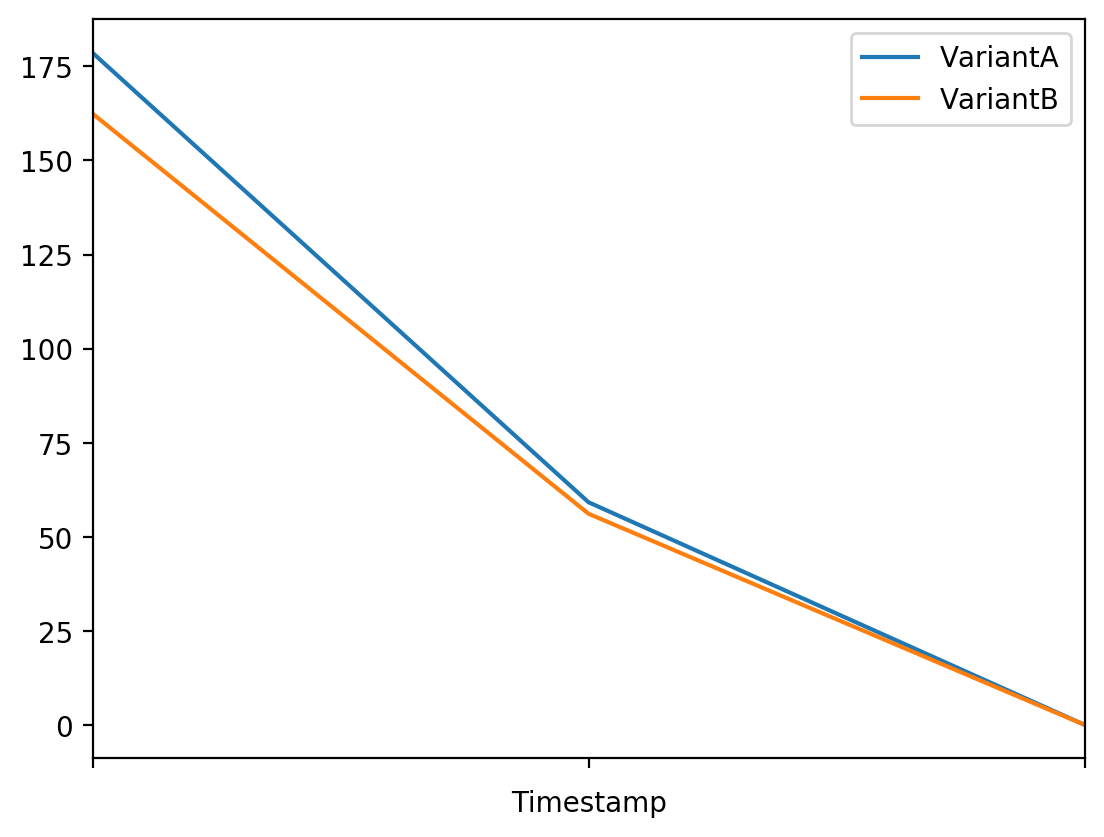

In [36]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(20)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="/aws/sagemaker/Endpoints", metric_name="CPUUtilization"
)

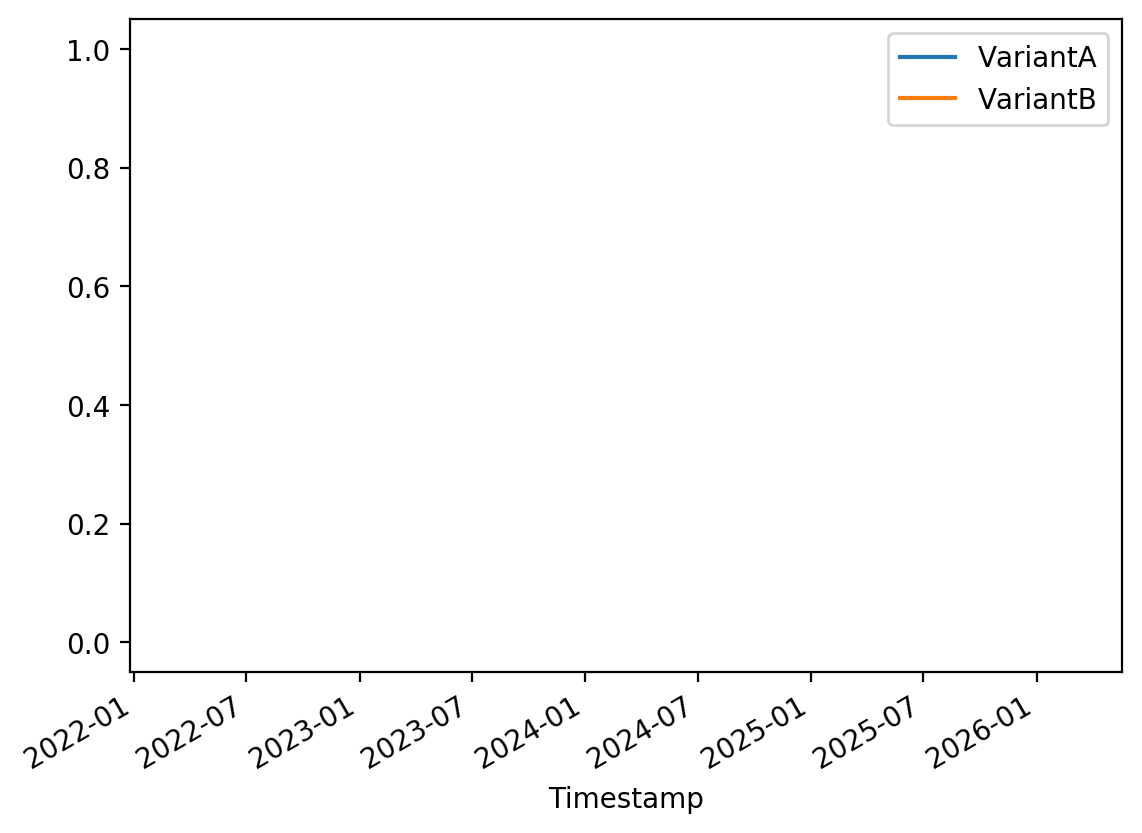

In [37]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="AWS/SageMaker", metric_name="Invocations"
)

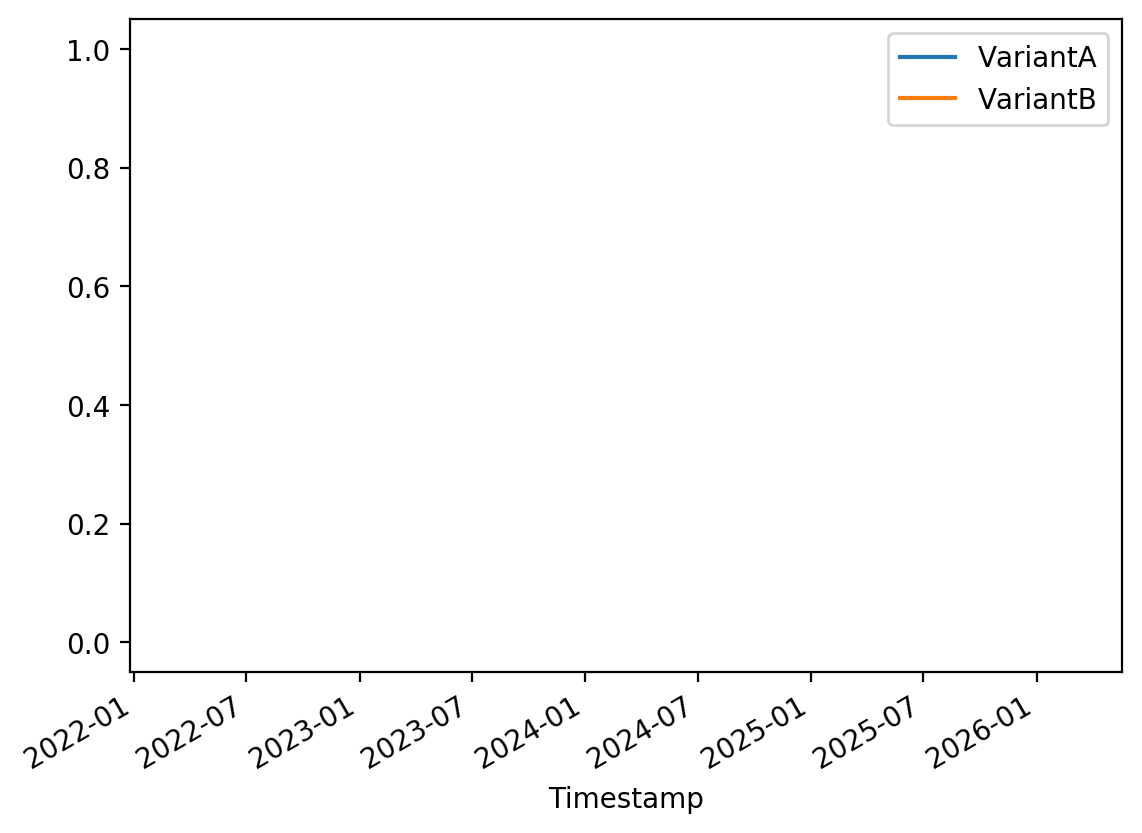

In [38]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="AWS/SageMaker", metric_name="InvocationsPerInstance"
)

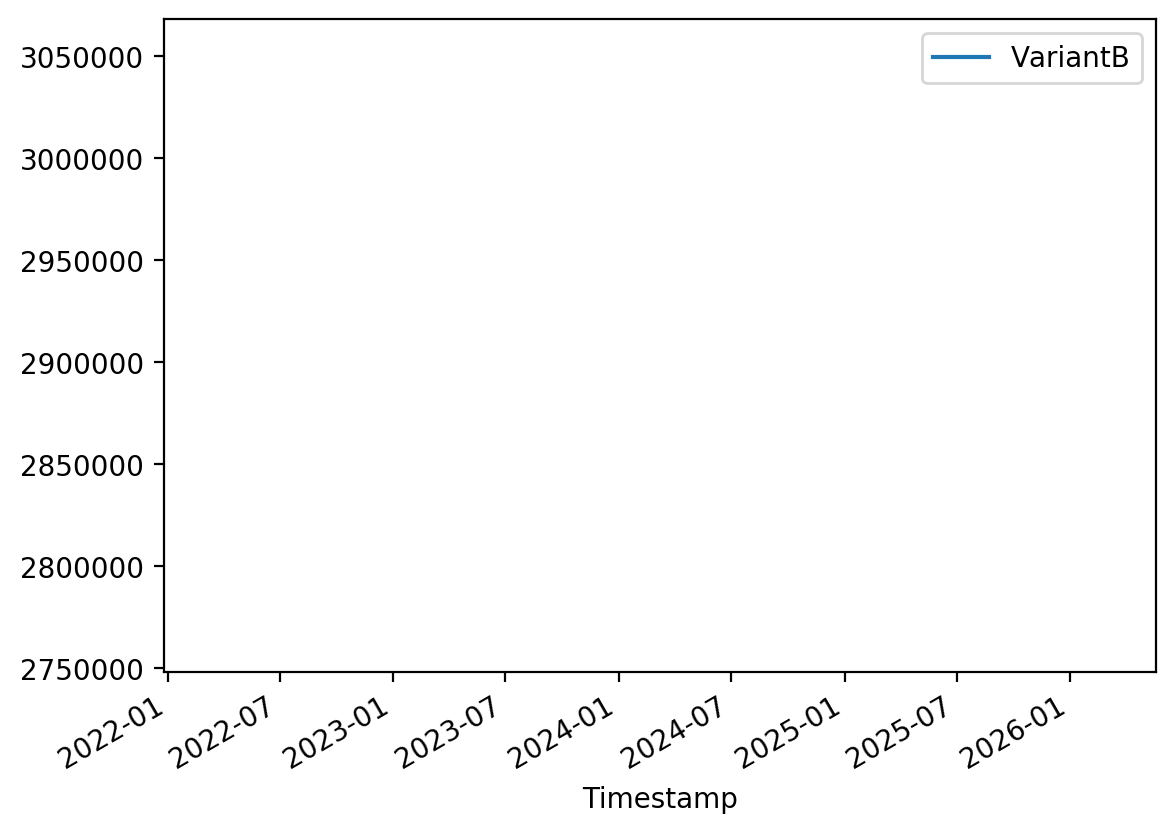

In [39]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="AWS/SageMaker", metric_name="ModelLatency"
)

# Shift All Traffic to Variant B
_**No downtime** occurs during this traffic-shift activity._

This may take a few minutes.  Please be patient.

In [40]:
updated_endpoint_config = [
    {
        "VariantName": variantA["VariantName"],
        "DesiredWeight": 0,
    },
    {
        "VariantName": variantB["VariantName"],
        "DesiredWeight": 100,
    },
]

In [41]:
sm.update_endpoint_weights_and_capacities(
    EndpointName=model_ab_endpoint_name, DesiredWeightsAndCapacities=updated_endpoint_config
)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:211125778552:endpoint/tensorflow-training-2024-03-03-04-02-13-539-abtest-1709771948',
 'ResponseMetadata': {'RequestId': 'c522708d-2a6e-409a-a085-19ac81aa2fa7',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c522708d-2a6e-409a-a085-19ac81aa2fa7',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '129',
   'date': 'Thu, 07 Mar 2024 00:43:36 GMT'},
  'RetryAttempts': 0}}

In [42]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint</a></b>'.format(
            region, model_ab_endpoint_name
        )
    )
)

# _Wait for the ^^ Endpoint Update ^^ to Complete Above_
This may take a few minutes.  Please be patient.

In [43]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

# Run Some More Predictions

In [44]:
df_sample_reviews["predicted_class"] = df_sample_reviews["review_body"].map(predict)
df_sample_reviews.head(5)

,index,review_body,star_rating,predicted_class
0,94784,This envelope printer makes my job easy. It st...,5,5
1,32426,This did not work. Everything seemed to go wel...,1,1
2,87898,Would rate higher if TurboTax didn't remove fu...,3,3
3,59292,"over a month since purchase, unable to use sen...",1,1
4,55344,Now I can feel safe about surfing the web know...,5,5


# Show the Metrics for Each Variant
If you see `Metrics not yet available`, please be patient as metrics may take a few mins to appear in CloudWatch.

Also, make sure the predictions ran successfully above.

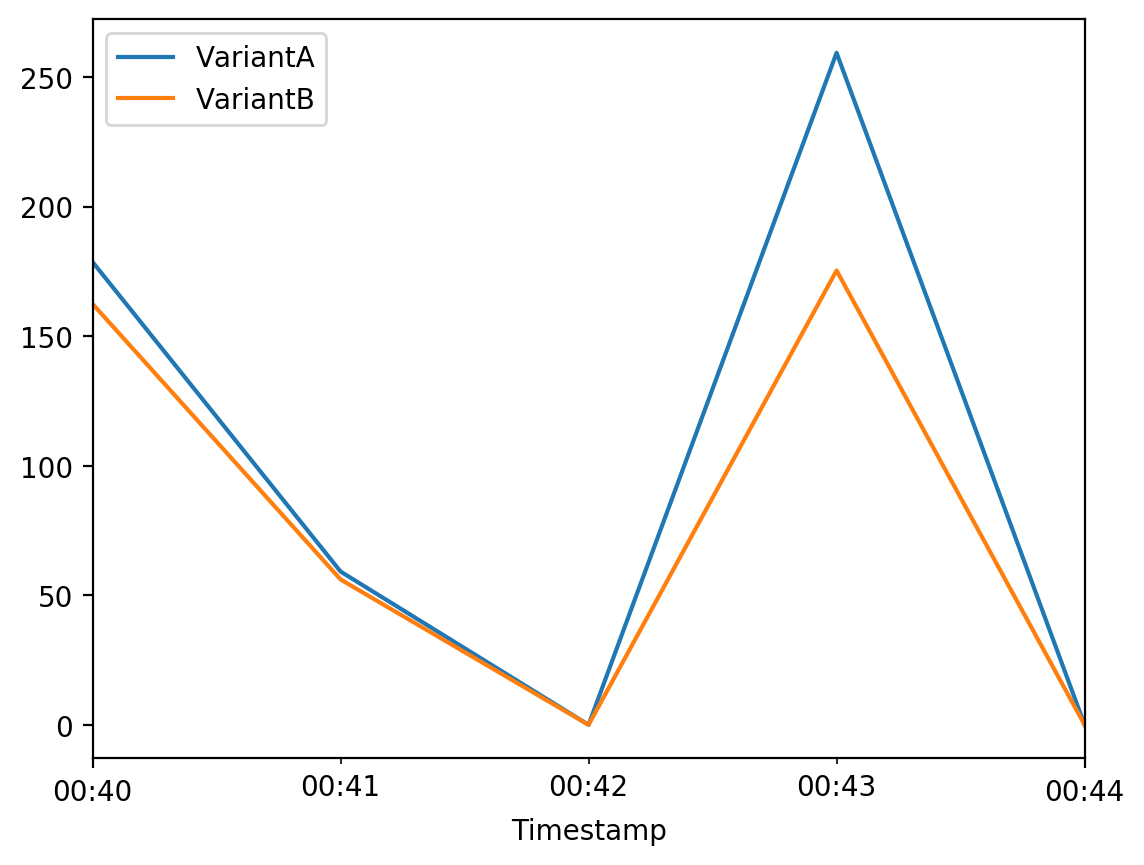

In [45]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(20)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="/aws/sagemaker/Endpoints", metric_name="CPUUtilization"
)

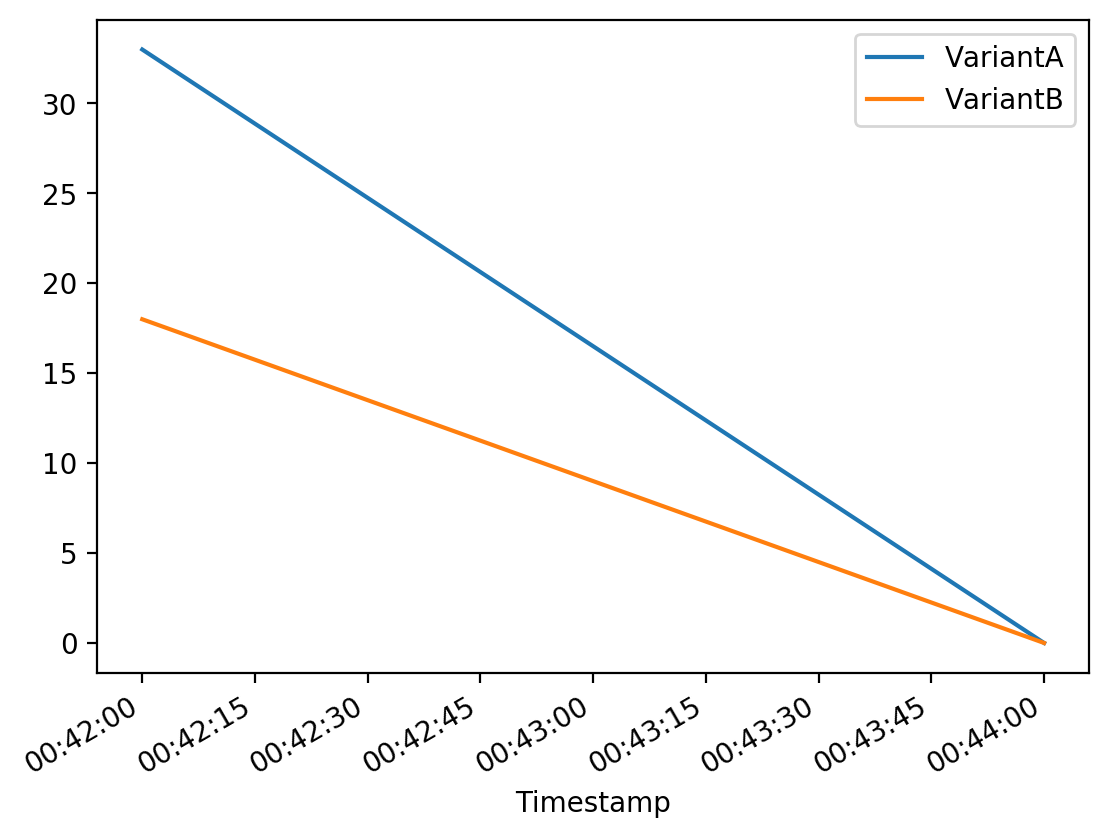

In [46]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="AWS/SageMaker", metric_name="Invocations"
)

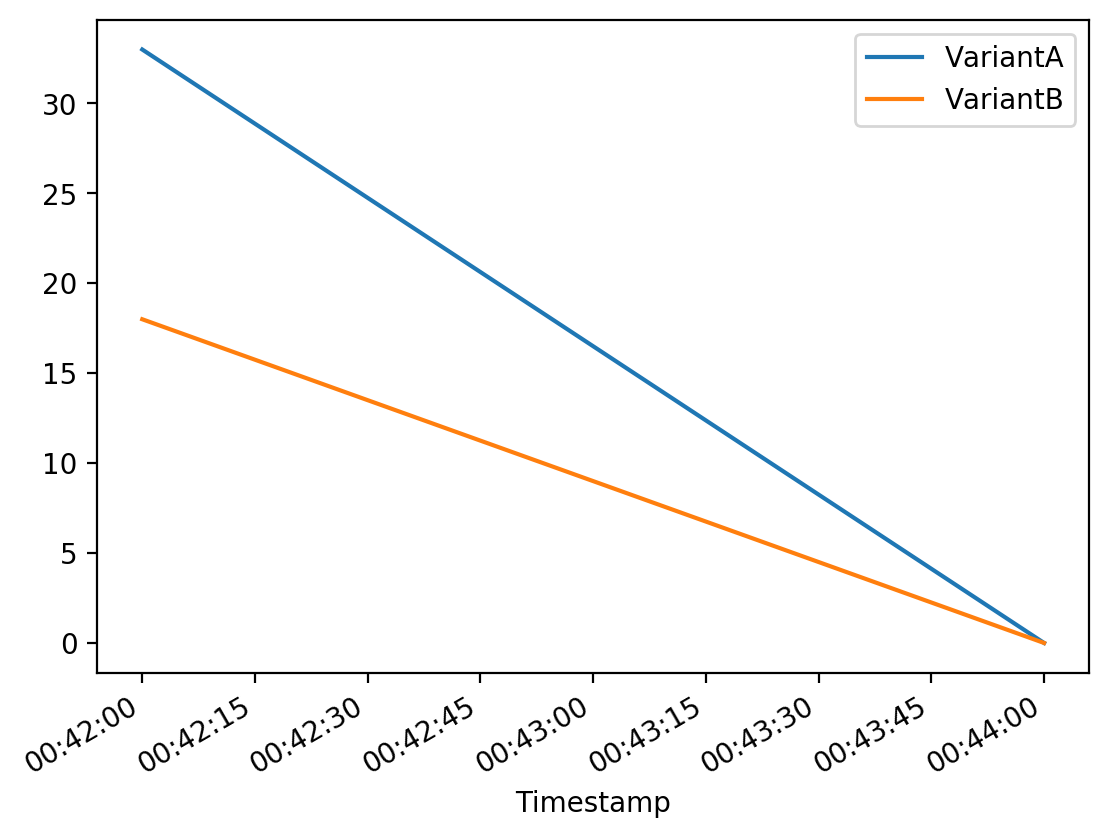

In [47]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="AWS/SageMaker", metric_name="InvocationsPerInstance"
)

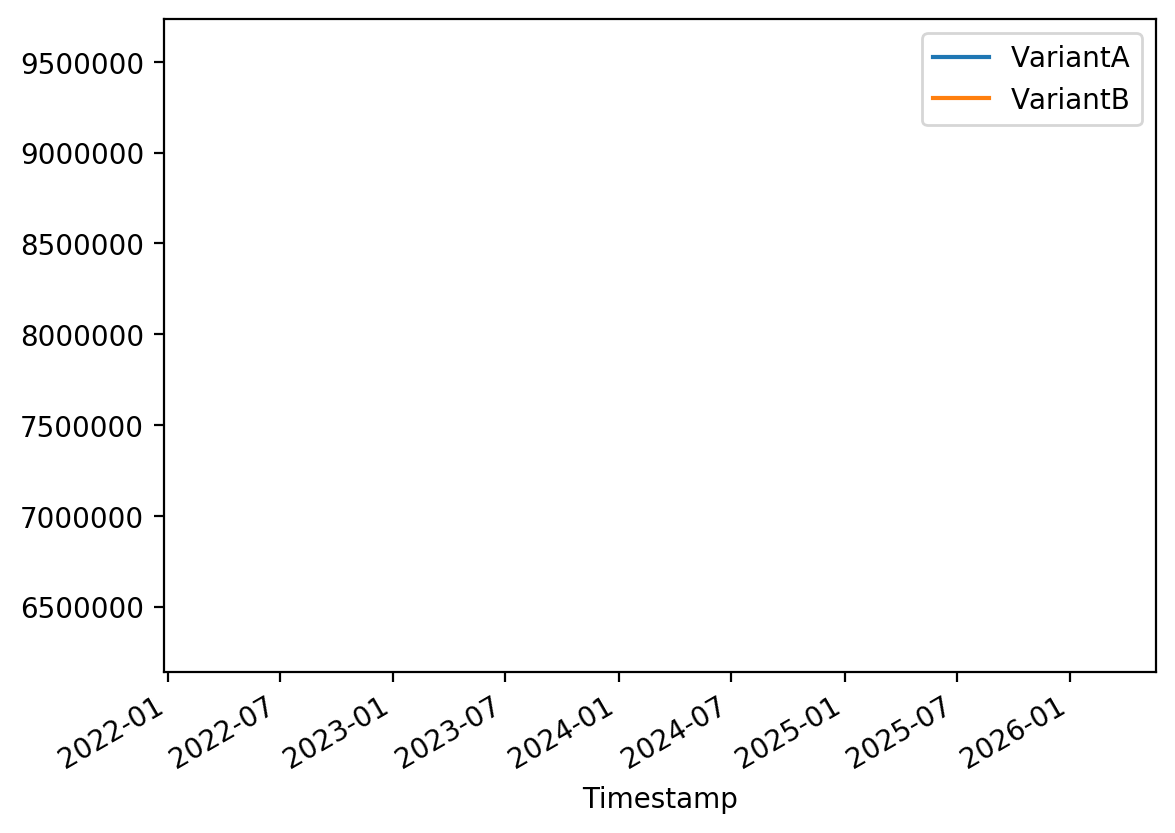

In [48]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="AWS/SageMaker", metric_name="ModelLatency"
)

# Remove Variant A to Reduce Cost
Modify the Endpoint Configuration to only use variant B.

_**No downtime** occurs during this scale-down activity._

This may take a few mins.  Please be patient.

In [49]:
import time

timestamp = "{}".format(int(time.time()))

updated_endpoint_config_name = "{}-{}".format(training_job_name, timestamp)

updated_endpoint_config = sm.create_endpoint_config(
    EndpointConfigName=updated_endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": variantB["VariantName"],
            "ModelName": model_b_name,  # Only specify variant B to remove variant A
            "InstanceType": "ml.m5.4xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 100,
        }
    ],
)

In [50]:
sm.update_endpoint(EndpointName=model_ab_endpoint_name, EndpointConfigName=updated_endpoint_config_name)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:211125778552:endpoint/tensorflow-training-2024-03-03-04-02-13-539-abtest-1709771948',
 'ResponseMetadata': {'RequestId': '68721ce9-21d8-4534-b6c9-2f9382161c66',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '68721ce9-21d8-4534-b6c9-2f9382161c66',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '129',
   'date': 'Thu, 07 Mar 2024 00:45:55 GMT'},
  'RetryAttempts': 0}}

# _If You See An ^^ Error ^^ Above, Please Wait Until the Endpoint is Updated_

In [51]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/endpoints/{}">REST Endpoint</a></b>'.format(
            region, model_ab_endpoint_name
        )
    )
)

# _Wait for the ^^ Endpoint Update ^^ to Complete Above_
This may take a few minutes.  Please be patient.

In [52]:
waiter = sm.get_waiter("endpoint_in_service")
waiter.wait(EndpointName=model_ab_endpoint_name)

# Run Some More Predictions

In [53]:
df_sample_reviews["predicted_class"] = df_sample_reviews["review_body"].map(predict)
df_sample_reviews

,index,review_body,star_rating,predicted_class
0,94784,This envelope printer makes my job easy. It st...,5,5
1,32426,This did not work. Everything seemed to go wel...,1,1
2,87898,Would rate higher if TurboTax didn't remove fu...,3,3
3,59292,"over a month since purchase, unable to use sen...",1,1
4,55344,Now I can feel safe about surfing the web know...,5,5
5,29376,most likely the worst purchase I made all year...,1,1
6,90222,BUy this directly form Adobe - it was impossib...,1,1
7,29639,"I have not fully used this, but I am trying it...",4,5
8,97152,Continues to be reasonable easy to use as with...,4,4
9,33149,"I've been an Intuit user for many years, since...",3,3


# Show the Metrics for Each Variant
If you see `Metrics not yet available`, please be patient as metrics may take a few mins to appear in CloudWatch.

Also, make sure the predictions ran successfully above.

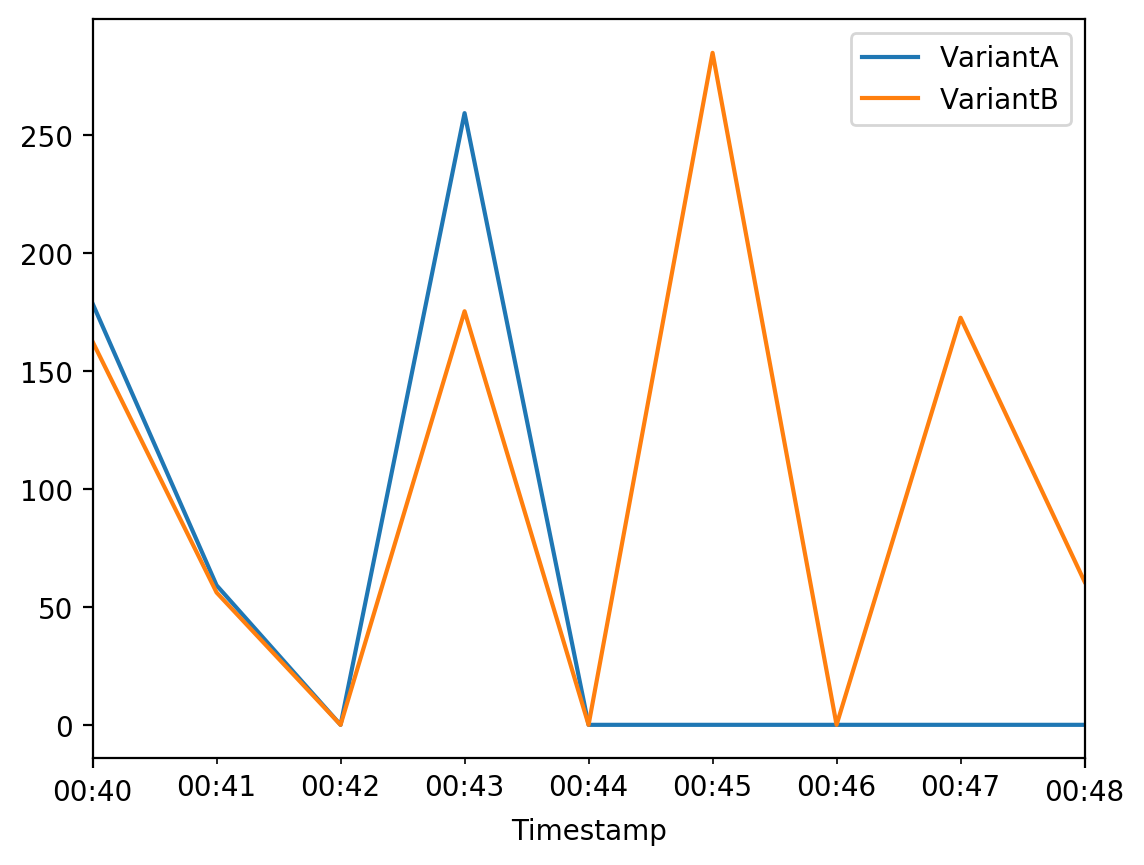

In [54]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(20)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="/aws/sagemaker/Endpoints", metric_name="CPUUtilization"
)

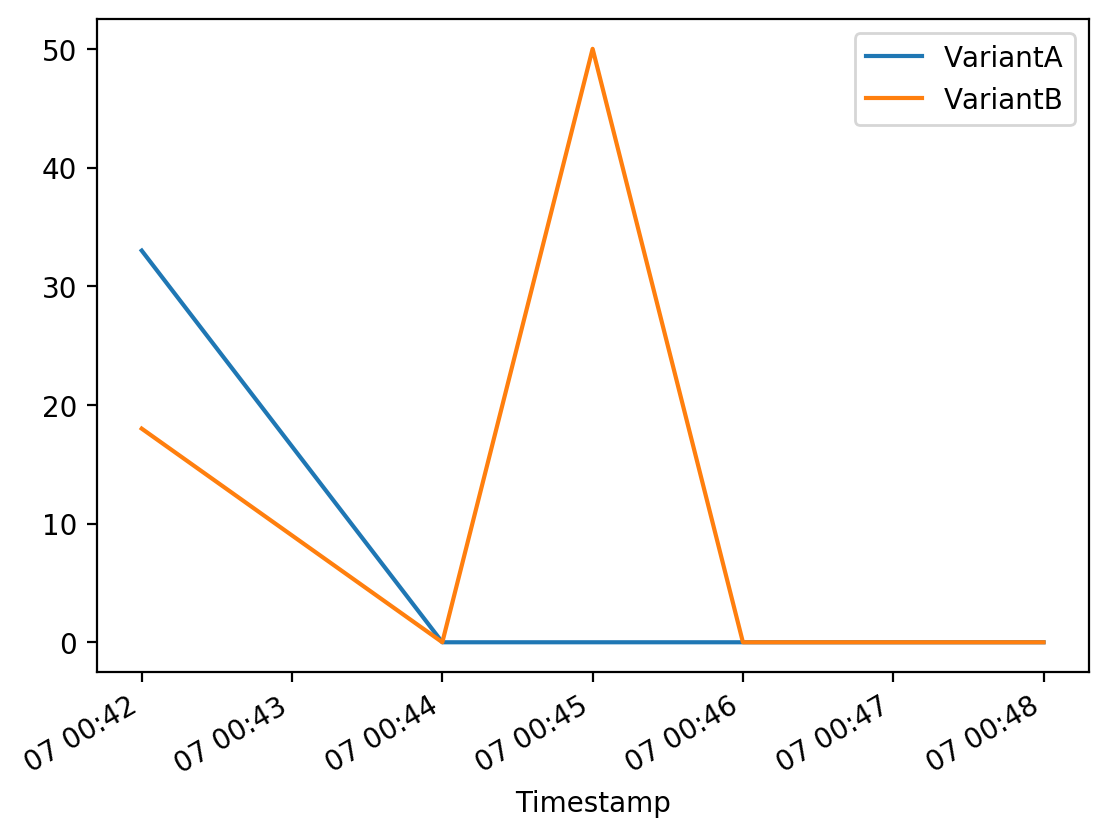

In [55]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="AWS/SageMaker", metric_name="Invocations"
)

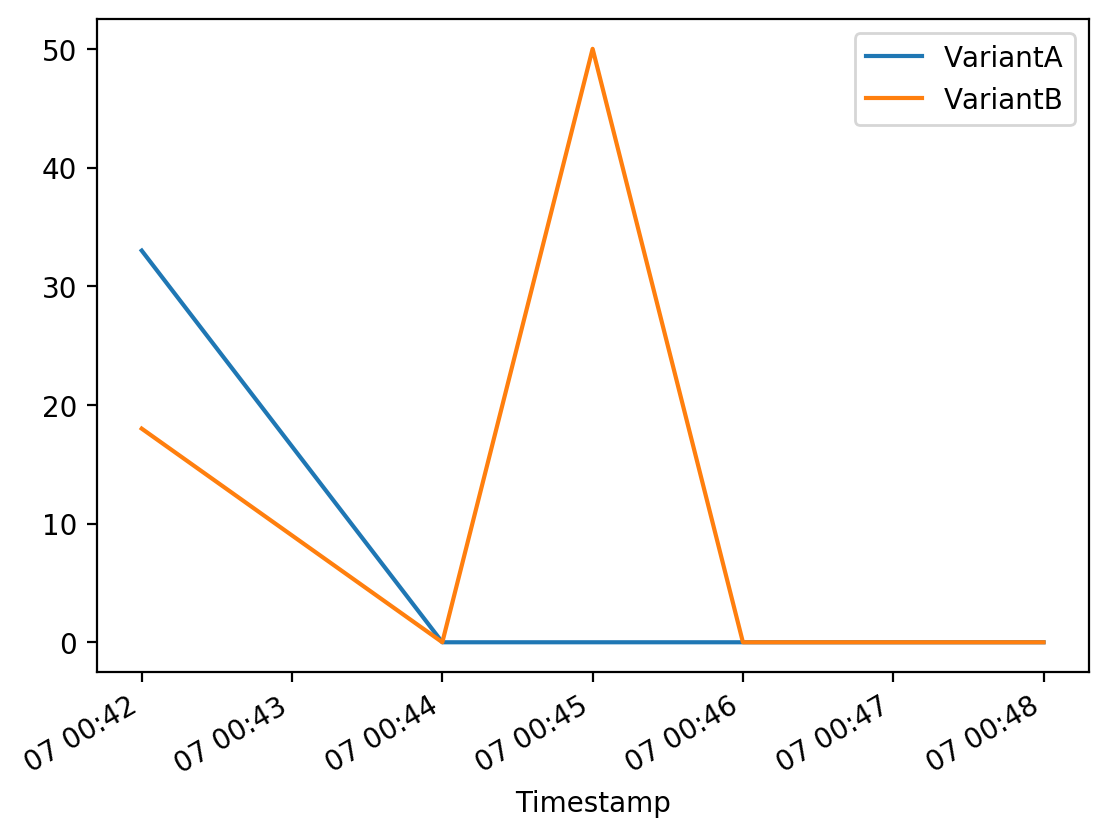

In [56]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="AWS/SageMaker", metric_name="InvocationsPerInstance"
)

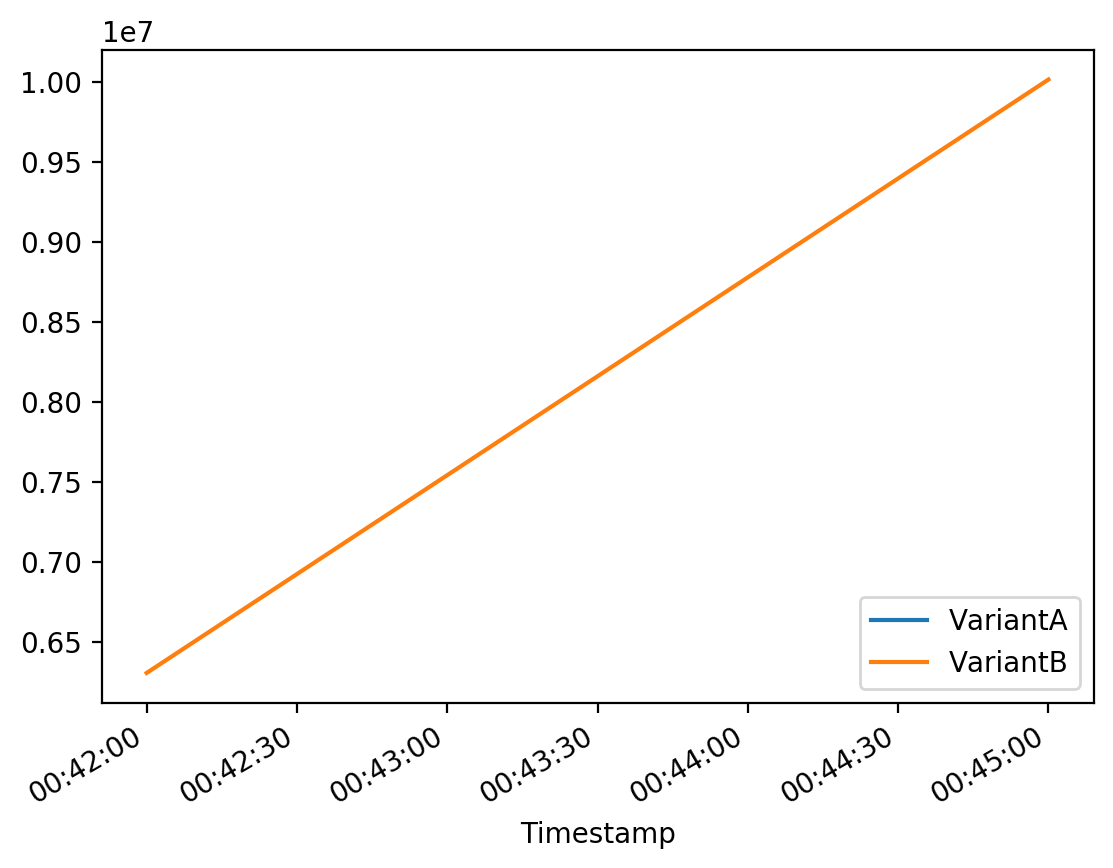

In [57]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

time.sleep(5)
plot_endpoint_metrics_for_variants(
    endpoint_name=model_ab_endpoint_name, namespace_name="AWS/SageMaker", metric_name="ModelLatency"
)

# More Links
* Optimize Cost with TensorFlow and Elastic Inference
https://aws.amazon.com/blogs/machine-learning/optimizing-costs-in-amazon-elastic-inference-with-amazon-tensorflow/

* Using API Gateway with SageMaker Endpoints
https://aws.amazon.com/blogs/machine-learning/creating-a-machine-learning-powered-rest-api-with-amazon-api-gateway-mapping-templates-and-amazon-sagemaker/

# Release Resources

In [58]:
sm.delete_endpoint(EndpointName=model_ab_endpoint_name)

{'ResponseMetadata': {'RequestId': '7c9c26a0-66f8-46a6-8915-db6e02bd2f1b',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '7c9c26a0-66f8-46a6-8915-db6e02bd2f1b',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Thu, 07 Mar 2024 00:49:48 GMT'},
  'RetryAttempts': 0}}

In [59]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [60]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>